## Transfer Learning 
We will fine-tune a pre-trained deep network (ResNet34) for a
particular two-class dataset which can be downloaded from the attached zip file. Code for pre-processing the dataset, and for loading ResNet34, can be found below. <br>
Since ResNet34 is for 1000 output classes, you will need to modify the last layer to reduce two classes. Train for 20 epochs and plot train and validation loss curves. Report your final train and validation accuracies.

In [0]:
from __future__ import print_function, division

import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np


Import the Data files and the pretrained RESNET34 Model

In [0]:

transforms = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406],
                       [0.229, 0.224, 0.225])
])

# Use the image folder function to create datasets
image_datasets = {x: datasets.ImageFolder(f"drive/My Drive/NYU/Course_Materials/Courses Taken/MachineLearning/Assignment5/data/{x}", transforms)
                  for x in['train', 'val']}

model = models.resnet34(pretrained=True)

Create Data Loaders for the train and val data 

In [0]:
NUM_EPOCHS = 10
BATCH_SIZE = 16
NUM_CLASSES = 2
feature_extract = True

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


Visualize few data points in the train data 

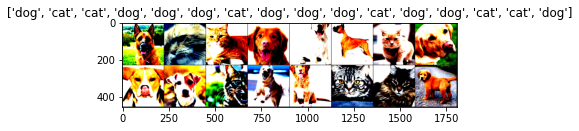

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders_dict['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Modify the Output layer to reduce to just 2 classes as required.

In [0]:
# intialize model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

Modify the Model parameters such that we only use grad for the Weights and the Bias. <br>
Also initialize the Optimizer for the model

In [0]:
params_to_update = model.parameters()

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Attach the Model to the GPU Runtime and define the Loss function

In [0]:
device = torch.device("cuda")
model = model.to(device)

# define loss funtion
criterion = nn.CrossEntropyLoss()

save_loss = {'train':[], 'val':[]}
save_acc = {'train':[], 'val':[]}


Write a train function that will train the model on the Train and Validation inputs for the number of Epochs defines.

In [0]:
def train_model(model, criterion, optimizer, num_epochs):

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            for batch_idx, (inputs, labels) in enumerate(dataloaders_dict[phase],1):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()
                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                
            # saving variable for plottin
            save_loss[phase] += [current_loss / dataset_sizes[phase]]
            save_acc[phase] += [current_corrects.double() / dataset_sizes[phase]]
          
            print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")

    return save_loss, save_acc

# Referenced - https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/    

Train the Model for the Number of Epochs

In [9]:
save_loss, save_acc = train_model(model, criterion, optimizer, NUM_EPOCHS)


Epoch:0 -- Phase:train -- Loss:0.78 -- Acc:45.00
Epoch:0 -- Phase:val -- Loss:0.43 -- Acc:87.50
Epoch:1 -- Phase:train -- Loss:0.47 -- Acc:83.33
Epoch:1 -- Phase:val -- Loss:0.21 -- Acc:100.00
Epoch:2 -- Phase:train -- Loss:0.18 -- Acc:100.00
Epoch:2 -- Phase:val -- Loss:0.10 -- Acc:100.00
Epoch:3 -- Phase:train -- Loss:0.10 -- Acc:100.00
Epoch:3 -- Phase:val -- Loss:0.05 -- Acc:100.00
Epoch:4 -- Phase:train -- Loss:0.05 -- Acc:100.00
Epoch:4 -- Phase:val -- Loss:0.04 -- Acc:100.00
Epoch:5 -- Phase:train -- Loss:0.02 -- Acc:100.00
Epoch:5 -- Phase:val -- Loss:0.03 -- Acc:100.00
Epoch:6 -- Phase:train -- Loss:0.02 -- Acc:100.00
Epoch:6 -- Phase:val -- Loss:0.03 -- Acc:100.00
Epoch:7 -- Phase:train -- Loss:0.03 -- Acc:100.00
Epoch:7 -- Phase:val -- Loss:0.02 -- Acc:100.00
Epoch:8 -- Phase:train -- Loss:0.01 -- Acc:100.00
Epoch:8 -- Phase:val -- Loss:0.02 -- Acc:100.00
Epoch:9 -- Phase:train -- Loss:0.01 -- Acc:100.00
Epoch:9 -- Phase:val -- Loss:0.02 -- Acc:100.00


Print the Final Train and Val Accuracies

In [10]:
print("Final Train Accuracy {}".format(save_acc['train'][-1]))
print("Final Val Accuracy {}".format(save_acc['val'][-1]))


Final Train Accuracy 1.0
Final Val Accuracy 1.0


Print the graph for Loss vs Epochs

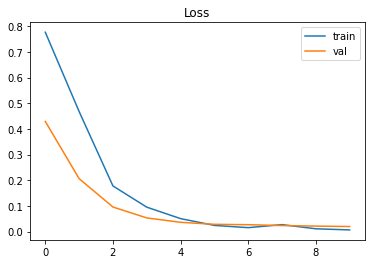

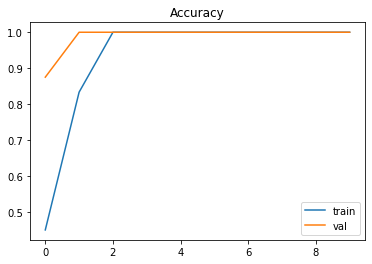

In [11]:
plt.plot(save_loss['train'])
plt.plot(save_loss['val'])
plt.legend(["train", "val"])
plt.title("Loss")
plt.show()

plt.plot(save_acc['train'])
plt.plot(save_acc['val'])
plt.legend(["train", "val"])
plt.title("Accuracy")
plt.show()
